In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline

In [2]:
qcom = pd.read_csv('QCOM.csv')

In [3]:
qclose = qcom['Close']

In [4]:
qclose = qclose.tolist()

In [5]:
action_level = 1

if action_level = 3, there are 3*2+1=7 actions to choose:  
1:buy with 1/3 cash u have,  
2:buy with 2/3 cash u have,  
3:buy with all cash u have,  
4:sell 1/3 stocks u have,  
5:sell 2/3 stocks u have,  
6:sell all stocks u have,  
7:hold.  
p.s. using the integer to represent te actions

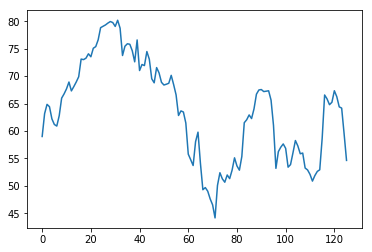

In [6]:
import matplotlib.pyplot as plt

def rough_plot(in_list, num_group):
    rough_list = list()
    tmp_sum = 0
    
    for i in range(1, len(qclose)):
        tmp_sum += qclose[i]
    
        if(i%num_group == num_group-1):
            rough_list.append(tmp_sum / num_group)
            tmp_sum = 0
            
    plt.plot(rough_list)
    
    
rough_plot(qclose, 10)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

def linear_pred(li_in):
    li = li_in.copy()
    
    li_arr = np.asarray(li)
    li_arr = np.reshape(li_arr, (len(li), 1))
    x_arr = np.arange(len(li))
    x_arr = np.reshape(x_arr, (len(li), 1))

    regr = linear_model.LinearRegression()
    regr.fit(x_arr, li_arr)
    pred = regr.predict(len(li))
    return pred[0, 0]


In [8]:
import sys

def next_state(state, action, action_level):
    next_state = state.copy()
    if (action > 2*action_level + 1) or action <= 0:
        sys.exit("error, action undefined!")

    if action >= 1 and action <= action_level:
        # then buy
        
        if state['HandCash'] > 0:
            next_state['HandCash'] = state['HandCash']*(1 - action/action_level)
            next_state['NumStock'] = state['NumStock'] + \
                                     (state['HandCash']/state['StockPrice'])*(action/action_level)

    elif action >= (action_level + 1) and action <= (action_level + action_level) :
        # then sell
        
        if state['NumStock'] > 0:
            next_state['NumStock'] = state['NumStock']*(1 - (action-action_level)/action_level)
            next_state['HandCash'] = state['HandCash'] + \
                                     (state['StockPrice']*state['NumStock'])*((action-action_level)/action_level)
    
    return next_state


def reward(state, init_invest):
    return (state['NumStock']*state['StockPrice'] + state['HandCash']) - init_invest


def my_reward_old(curr, last):
    return (curr['NumStock']*curr['StockPrice'] + curr['HandCash']) - \
           (last['NumStock']*last['StockPrice'] + last['HandCash'])
    
def my_reward(curr, last):
    k = (curr['NumStock']*curr['StockPrice'] + curr['HandCash']) - \
           (last['NumStock']*last['StockPrice'] + last['HandCash'])
    if k < 0:
        k = k*10
    return k

In [79]:
# feature 1 : indicate the difference of #stock after the action from the state
# state is a dictionary with 3 elements
def feature_1(state, action, action_level):
    if (action > 2*action_level + 1) or action <= 0:
        sys.exit("error, action undefined!")
        
    elif action >= 1 and action <= action_level: # buy
        tmp = (state['HandCash']/state['StockPrice'])*(action/action_level)
        if tmp > feature_1.max:
            feature_1.max = tmp
            return 1
        elif tmp < feature_1.min:
            feature_1.min = tmp
            return 0
        else:
            return (tmp - feature_1.min) / (feature_1.max - feature_1.min)

    elif action >= (action_level + 1) and action <= (action_level + action_level) : # sell
        tmp = (-1)*state['NumStock'] * ((action-action_level)/action_level)
        if tmp > feature_1.max:
            feature_1.max = tmp
            return 1
        elif tmp < feature_1.min:
            feature_1.min = tmp
            return 0
        else:
            return (tmp - feature_1.min) / (feature_1.max - feature_1.min)

    elif action == (2*action_level + 1): # hold
        return 0
feature_1.max = 1
feature_1.min = 0
    

# feature 2 : indicate the difference of #Cash in Hand after the action from the state
def feature_2(state, action, action_level):
    if (action > 2*action_level + 1) or action <= 0:
        sys.exit("error, action undefined!")
        
    elif action >= 1 and action <= action_level: # buy
        tmp = (-1)*state['HandCash'] * (action/action_level)
        if tmp > feature_2.max:
            feature_2.max = tmp
            return 1
        elif tmp < feature_2.min:
            feature_2.min = tmp
            return 0
        else:
            return (tmp - feature_2.min) / (feature_2.max - feature_2.min)

    elif action >= (action_level + 1) and action <= (action_level + action_level) : # sell
        tmp = state['StockPrice']*state['NumStock'] * ((action-action_level)/action_level)
        if tmp > feature_2.max:
            feature_2.max = tmp
            return 1
        elif tmp < feature_2.min:
            feature_2.min = tmp
            return 0
        else:
            return (tmp - feature_2.min) / (feature_2.max - feature_2.min)

    elif action == (2*action_level + 1): # hold
        return 0
feature_2.max = 1
feature_2.min = 0

    
# linear_based_rwd    
def feature_3(price_list, state, action, action_level):
    if (action > 2*action_level + 1) or action <= 0:
        sys.exit("error, action undefined!")
    
    next_price = linear_pred(price_list)
    next_s = next_state(state, action, action_level)
    next_s['StockPrice'] = next_price
        
    tmp = my_reward(next_s, state)
    if tmp > feature_3.max:
        feature_3.max = tmp
        return 1
    elif tmp < feature_3.min:
        feature_3.min = tmp
        return 0
    else:
        return (tmp - feature_3.min) / (feature_3.max - feature_3.min)
    
    #return my_reward(next_s, state)/100
feature_3.max = 1
feature_3.min = 0


def feature_4(price_list, state, action, action_level):
    if (action > 2*action_level + 1) or action <= 0:
        sys.exit("error, action undefined!")
    
    next_price = linear_pred(price_list)
    next_s = next_state(state, action, action_level)
    next_s['StockPrice'] = next_price
    
    if next_price >= state['StockPrice']:
        best_action = action_level # buy with all cash u have
    else:
        best_action = 2*action_level # sell all stocks u have
    best_next_s = next_state(state, best_action, action_level)
    best_next_s['StockPrice'] = next_price
    
    
    tmp = my_reward(best_next_s, state) - my_reward(next_s, state)
    if tmp > feature_3.max:
        feature_3.max = tmp
        return 1
    elif tmp < feature_3.min:
        feature_3.min = tmp
        return 0
    else:
        return (tmp - feature_3.min) / (feature_3.max - feature_3.min)
feature_4.max = 1
feature_4.min = 0

#
def feature_5(price_list, state, action, action_level):
    if(action > 2*action_level + 1) or action <= 0:
        sys.exit("error, action undefined!")
        
    price_avg = sum(price_list) / float(len(price_list))
    
    #stock price is higher than avg_price means the stock is going upper
    if price_avg <= state['StockPrice']:
        price_trend = 1
    else:
        price_trend = 0
    
    #stock is going upper we need to buy
    if price_trend == 1:
        if action <= action_level:
            return action/float(action_level)
        elif action_level < action and action <= 2*action_level :
            return -(action - action_level)/float(action_level)
        else:
            return 0
    #stock is going down ,not to buy
    elif price_trend == 0:
        if action <= action_level:
            return -(action/float(action_level))
        elif action_level < action and action <= 2*action_level:
            return (action - action_level)/float(action_level)
        else:
            return 0
        
        
def feature_5(price_list, state, action, action_level):
    if(action > 2*action_level) or action < 0:
        sys.exit("error, action undefined!")
        
    price_avg = sum(price_list) / float(len(price_list))
    
    #stock price is higher than avg_price means the stock is going upper
    if price_avg <= state['StockPrice']:
        price_trend = 1
    else:
        price_trend = 0
    
    #stock is going upper we need to buy
    if price_trend == 1:
        if(action <= action_level):
            return (action + action_level)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            return (-1)*(action - 2*action_level)/float(2*action_level)
    #stock is going down, sell
    elif price_trend == 0:
        if(action <= action_level):
            return (action_level - action)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            return (action)/float(2*action_level)

In [98]:
from random import randint
def Q_value(price_list, state, action, w, action_level):
    if (action > 2*action_level + 1) or action <= 0:
        sys.exit("error, action undefined!")
    
    return w[0]*feature_1(state, action, action_level) + \
           w[1]*feature_2(state, action, action_level) + \
           w[4]*feature_5(price_list, state, action, action_level)
           #w[2]*feature_3(price_list, state, action, action_level)+ \
           #w[3]*feature_4(price_list, state, action, action_level)
            
    

def V_value(price_list, state, w, action_level):
    v = 0
    first = 1 # flag of the frist iteration
    v_act = ''
    for action in range(1, (2*action_level + 1) + 1):
        curr_q = Q_value(price_list, state, action, w, action_level)
        if first == 1:
            first = 0
            v = curr_q
            v_act = action
        elif curr_q > v:
            v = curr_q
            v_act = action
        elif curr_q == v:
            flip = randint(0, 1)
            if flip == 1:
                v = curr_q
                v_act = action
    return [v, v_act]

In [99]:
class StockQLData:
    'Result data of approximated q-learning of stock price'
    
    def __init__(self, action_level):
        self.last_reward = list()
        self.last = list()
        self.last_w = list()
        self.rwd_sum = 0
        self.avg_my_reward = list()

        self.act_num = np.zeros((action_level*2 + 1) + 1)
        self.act_num_list = list()
        
        
    def point_update_action(self, last_act):
        self.act_num[last_act] += 1

    
    def point_update_my_rwd_sum(self, state, last_state):
        self.rwd_sum += my_reward(state, last_state) 
            
        
    def last_point(self, trial_length, state, init_invest, w):
        self.avg_my_reward.append(self.rwd_sum/(trial_length-1)) #ignore the first reward(=0)
        self.last_reward.append(reward(state, init_invest))
        cp_w = w.copy()
        self.last_w.append(cp_w)

        tmp_act_num = self.act_num.copy()
        self.act_num_list.append(tmp_act_num)
        
        self.rwd_sum = 0

        self.act_num.fill(0)
    

after an action ---> call it the (new) state  
here: last_state_bf_act -> |act| -> last_state -> |new price release| -> (new) state  
but the last_state can be dismiss because when calculating(my_reward), it can be alternated by last_state_bf_act and keep the rule of the first line(i.e. after an action ---> call it the (new) state)

In [107]:
from random import randint
import math

init_invest = 10000
# initial state
state = {'NumStock': 0, 'StockPrice': qclose[0], 'HandCash': init_invest}
last_state = {'NumStock': 0, 'StockPrice': qclose[0], 'HandCash': init_invest}
last_state_bf_act = {'NumStock': 0, 'StockPrice': qclose[0], 'HandCash': init_invest}
#last_act = 'HOLD'
#last_act = 2*action_level+1
last_act = action_level


w = [-0.1, -0.1, -0.1, -0.1, -0.1]
tmp_w = [0, 0, 0, 0, 0]
ita = 0.2
epsilon = 0.2
gama = 0

f3_x_num = 5

sqld = StockQLData(action_level)

for trial in range(0, 2000):
    
    state = {'NumStock': 0, 'StockPrice': qclose[0], 'HandCash': init_invest}
    last_state = {'NumStock': 0, 'StockPrice': qclose[0], 'HandCash': init_invest}
    last_state_bf_act = {'NumStock': 0, 'StockPrice': qclose[0], 'HandCash': init_invest}
    
    for point in range(f3_x_num, len(qclose)):
    #for point in range(f3_x_num, 10):

        # new price revealed!
        state['NumStock'] = last_state['NumStock']
        state['HandCash'] = last_state['HandCash']
        state['StockPrice'] = qclose[point]
        
        # collect data           
        sqld.point_update_action(last_act)        
        sqld.point_update_my_rwd_sum(state, last_state)
        
        if point == len(qclose)-1:
            #print('in loop watch w: ', w)
            sqld.last_point(len(qclose), state, init_invest, w)
        
        
        # prepare for the arguments passed later
        last_f3_list = qclose[point-f3_x_num:point]
        curr_f3_list = qclose[point-f3_x_num+1:point+1]
        
        tmp_w[0] = w[0] - ita * \
                          (Q_value(last_f3_list, last_state_bf_act, last_act, w, action_level) - 
                              (my_reward(state, last_state) + gama*V_value(curr_f3_list, state, w, action_level)[0])) * \
                          feature_1(last_state_bf_act, last_act, action_level)
                
        tmp_w[1] = w[1] - ita * \
                          (Q_value(last_f3_list, last_state_bf_act, last_act, w, action_level) - 
                              (my_reward(state, last_state) + gama*V_value(curr_f3_list, state, w, action_level)[0])) * \
                          feature_2(last_state_bf_act, last_act, action_level)
                
        #tmp_w[2] = w[2] - ita * \
        #                  (Q_value(last_f3_list, last_state_bf_act, last_act, w, action_level) - 
        #                      (my_reward(state, last_state) + gama*V_value(curr_f3_list, state, w, action_level)[0])) * \
        #                  feature_3(last_f3_list, last_state_bf_act, last_act, action_level)
                
        #tmp_w[3] = w[3] - ita * \
        #                  (Q_value(last_f3_list, last_state_bf_act, last_act, w, action_level) - 
        #                      (my_reward(state, last_state) + gama*V_value(curr_f3_list, state, w, action_level)[0])) * \
        #                  feature_4(last_f3_list, last_state_bf_act, last_act, action_level)
                
        tmp_w[4] = w[4] - ita *\
                          (Q_value(last_f3_list, last_state_bf_act, last_act, w, action_level) - 
                              (my_reward(state, last_state) + gama*V_value(curr_f3_list, state, w, action_level)[0])) * \
                          feature_5(last_f3_list, last_state_bf_act, last_act, action_level)
                
        for i in range(0, len(w)):
            w[i] = tmp_w[i]
        
        
        last_state_bf_act = state.copy()
        
        # determine the next state
        if randint(1, 10) <= 10*epsilon:
            # act randomly
            last_act = randint(1, 2*action_level + 1)
        else:
            last_act = (V_value(curr_f3_list, state, w, action_level))[1]

        last_state = next_state(state, last_act, action_level)

In [108]:
sum(sqld.last_reward) / float(len(sqld.last_reward))

-402.87107217444003

In [109]:
print(w[0],w[1],w[4])

-964.3769466783814 239.97406543565518 -270.7938315112027


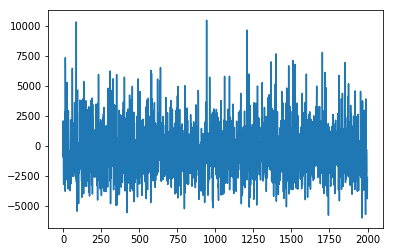

In [110]:
import matplotlib.pyplot as plt
plt.plot(sqld.last_reward)
#plt.subplot(1, 2, 1)

(array([  6.,  24.,  81., 138., 258., 344., 285., 257., 208., 169., 100.,
         61.,  25.,  15.,  16.,   7.,   3.,   0.,   0.,   3.]),
 array([-6023.77469653, -5199.49371909, -4375.21274165, -3550.93176421,
        -2726.65078677, -1902.36980933, -1078.08883189,  -253.80785445,
          570.47312298,  1394.75410042,  2219.03507786,  3043.3160553 ,
         3867.59703274,  4691.87801018,  5516.15898762,  6340.43996506,
         7164.7209425 ,  7989.00191993,  8813.28289737,  9637.56387481,
        10461.84485225]),
 <a list of 20 Patch objects>)

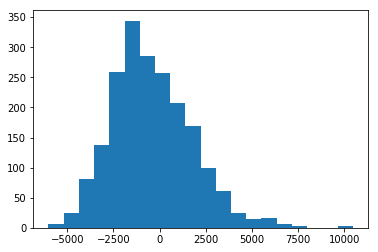

In [111]:
plt.hist(sqld.last_reward, bins = 20)

QCOM, trial = 7, gama = 0 : 2421  
QCOM, trial = 20, gama = 0 : 2395  
QCOM, trial = 20, gama = 0(w -0.1) : 2493  -43.16 1.69 -353.30 216.87  
QCOM, trial = 20, gama = 0.2(w -0.1) : 2606 85.33 47.49 -397.81 250.80

GOOG, trial = 7, gama = 0 :         7763  
GOOG, trial = 7, gama = 0 :         8319,  57.95 -11.72 -221.48 167.80  
GOOG, trial = 7, gama = 0(w -0.1) : 6781, -226.56 -34.06 -98.30 265.16  
GOOG, trial = 20, gama = 0.2(w -0.1) : 6090 58.29 32.33 -125.49 28.54  


NOK,  trial = 7, gama = 0 : 8605  
NOK, trial = 20, gama = 0.2(w -0.1) : 4575 -20.53 -69.28 -448.29 479.15

In [112]:
sqld.act_num_list

[array([  0., 121., 135., 999.]),
 array([   0.,   90.,  152., 1013.]),
 array([  0., 105., 186., 964.]),
 array([  0.,  96., 181., 978.]),
 array([  0.,  90., 172., 993.]),
 array([  0.,  89., 179., 987.]),
 array([   0.,   98.,  153., 1004.]),
 array([   0.,   96.,  138., 1021.]),
 array([   0.,   95.,  141., 1019.]),
 array([  0.,  90., 181., 984.]),
 array([  0.,  93., 193., 969.]),
 array([   0.,   88.,  162., 1005.]),
 array([   0.,   90.,  145., 1020.]),
 array([  0.,  89., 241., 925.]),
 array([   0.,  103.,  133., 1019.]),
 array([  0.,  93., 224., 938.]),
 array([   0.,  102.,  130., 1023.]),
 array([  0., 104., 195., 956.]),
 array([   0.,   99.,  146., 1010.]),
 array([   0.,   79.,  146., 1030.]),
 array([  0.,  91., 181., 983.]),
 array([   0.,   90.,  144., 1021.]),
 array([   0.,   83.,  134., 1038.]),
 array([  0., 113., 149., 993.]),
 array([   0.,   99.,  156., 1000.]),
 array([   0.,   93.,  152., 1010.]),
 array([  0., 106., 166., 983.]),
 array([  0.,  95., 188., 

(array([  3.,   3.,  10.,  14.,  34.,  47.,  61.,  77., 122., 136., 181.,
        163., 155., 130., 139., 118., 113.,  95.,  94.,  75.,  56.,  44.,
         31.,  30.,  15.,  10.,   9.,   6.,   8.,   8.,   3.,   4.,   1.,
          2.,   0.,   0.,   0.,   0.,   1.,   2.]),
 array([-6023.77469653, -5611.63420781, -5199.49371909, -4787.35323037,
        -4375.21274165, -3963.07225293, -3550.93176421, -3138.79127549,
        -2726.65078677, -2314.51029805, -1902.36980933, -1490.22932061,
        -1078.08883189,  -665.94834317,  -253.80785445,   158.33263426,
          570.47312298,   982.6136117 ,  1394.75410042,  1806.89458914,
         2219.03507786,  2631.17556658,  3043.3160553 ,  3455.45654402,
         3867.59703274,  4279.73752146,  4691.87801018,  5104.0184989 ,
         5516.15898762,  5928.29947634,  6340.43996506,  6752.58045378,
         7164.7209425 ,  7576.86143122,  7989.00191993,  8401.14240865,
         8813.28289737,  9225.42338609,  9637.56387481, 10049.70436353,
      

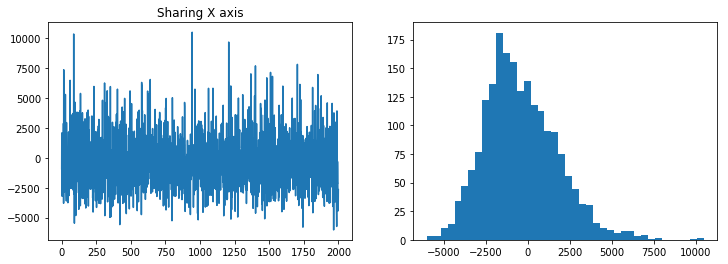

In [113]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(1, 2, figsize=(12, 4))
axarr[0].plot(sqld.last_reward)
axarr[0].set_title('Sharing X axis')
axarr[1].hist(sqld.last_reward, bins = 40)